# MUSIC GENRE DETECTION

### Importing Libraries 

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import json

import librosa
import librosa.display
import IPython.display as ipd

import warnings
warnings.filterwarnings('ignore')

from pydub import AudioSegment
import tensorflow.keras as keras

import os
import re
import csv

import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

In [2]:
#List of genres in the dataset
print(list(os.listdir(".\\Dataset\\Data\\genres_original")))

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [3]:
dataset_path='.\\Dataset\\Data\\genres_original'
data_soundwaves=[]
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(".\\Dataset\\Data\\genres_original")):
     if dirpath is not dataset_path:
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                signal, sr = librosa.load(file_path)
                data_soundwaves.append([re.split(r'[_.]', f)[0],f,signal, sr])

In [4]:
df_soundwaves = pd.DataFrame(data_soundwaves, columns = ['genre_name','filename','sound_wave','sr'])
df_soundwaves

,genre_name,filename,sound_wave,sr
0,blues,blues.00000.wav,"[0.0073242188, 0.016601562, 0.0076293945, -0.0...",22050
1,blues,blues.00001.wav,"[0.0034179688, 0.0043029785, 0.001373291, 0.00...",22050
2,blues,blues.00002.wav,"[0.019012451, 0.047698975, 0.029418945, -0.018...",22050
3,blues,blues.00003.wav,"[-0.013000488, -0.03060913, -0.036071777, -0.0...",22050
4,blues,blues.00004.wav,"[-0.0063171387, -0.009277344, -0.008331299, -0...",22050
...,...,...,...,...
994,rock,rock.00095.wav,"[-0.0826416, -0.12426758, -0.09277344, -0.0747...",22050
995,rock,rock.00096.wav,"[0.07272339, 0.10369873, 0.10211182, 0.1071167...",22050
996,rock,rock.00097.wav,"[-0.03414917, -0.038360596, 0.0030822754, 0.02...",22050
997,rock,rock.00098.wav,"[0.0859375, 0.14483643, 0.14294434, 0.1555481,...",22050


In [5]:
df_soundwaves_single = df_soundwaves.drop_duplicates(subset=['genre_name'])
df_soundwaves_single

,genre_name,filename,sound_wave,sr
0,blues,blues.00000.wav,"[0.0073242188, 0.016601562, 0.0076293945, -0.0...",22050
100,classical,classical.00000.wav,"[-0.020080566, -0.017486572, 0.004180908, 0.00...",22050
200,country,country.00000.wav,"[-0.13415527, -0.19485474, -0.04257202, 0.0528...",22050
300,disco,disco.00000.wav,"[-0.23202515, -0.23168945, -0.1979065, -0.1631...",22050
400,hiphop,hiphop.00000.wav,"[-0.16915894, -0.021697998, 0.019561768, -0.07...",22050
500,jazz,jazz.00000.wav,"[-0.009246826, -0.011779785, -0.013702393, -0....",22050
599,metal,metal.00000.wav,"[-0.12237549, -0.049194336, 0.044403076, 0.109...",22050
699,pop,pop.00000.wav,"[-0.0887146, -0.09524536, -0.102752686, -0.113...",22050
799,reggae,reggae.00000.wav,"[0.010375977, 0.007751465, 0.038879395, 0.0934...",22050
899,rock,rock.00000.wav,"[-0.033447266, -0.054901123, -0.054351807, -0....",22050


In [6]:
data_soundwaves_single=df_soundwaves_single.to_numpy()
data_soundwaves_single

array([['blues', 'blues.00000.wav',
        array([ 0.00732422,  0.01660156,  0.00762939, ..., -0.05560303,
               -0.06106567, -0.06417847], dtype=float32)               ,
        22050],
       ['classical', 'classical.00000.wav',
        array([-0.02008057, -0.01748657,  0.00418091, ...,  0.01934814,
                0.027771  ,  0.03131104], dtype=float32)               ,
        22050],
       ['country', 'country.00000.wav',
        array([-0.13415527, -0.19485474, -0.04257202, ...,  0.2260437 ,
                0.15042114,  0.04238892], dtype=float32)               ,
        22050],
       ['disco', 'disco.00000.wav',
        array([-0.23202515, -0.23168945, -0.1979065 , ..., -0.17419434,
               -0.14257812, -0.10617065], dtype=float32)               ,
        22050],
       ['hiphop', 'hiphop.00000.wav',
        array([-0.16915894, -0.021698  ,  0.01956177, ...,  0.07662964,
                0.03872681, -0.02105713], dtype=float32)               ,
        22050],
 

In [7]:
def waveplot(sound_wave):
    plt.figure(figsize = (16, 6))
    plt.title(sound_wave[0])
    librosa.display.waveplot(y=sound_wave[2], sr=sound_wave[3], color="#2f7d92ff")
    plt.show()

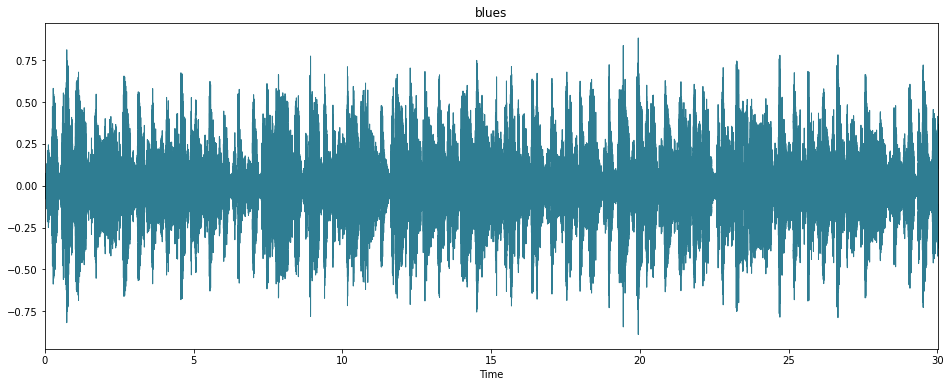

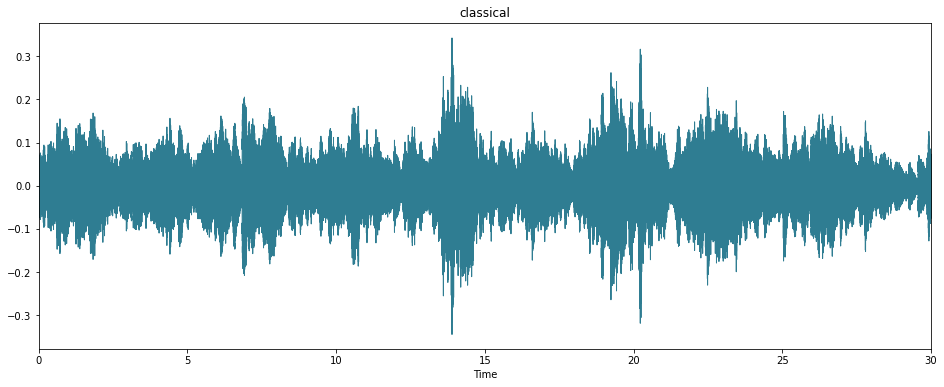

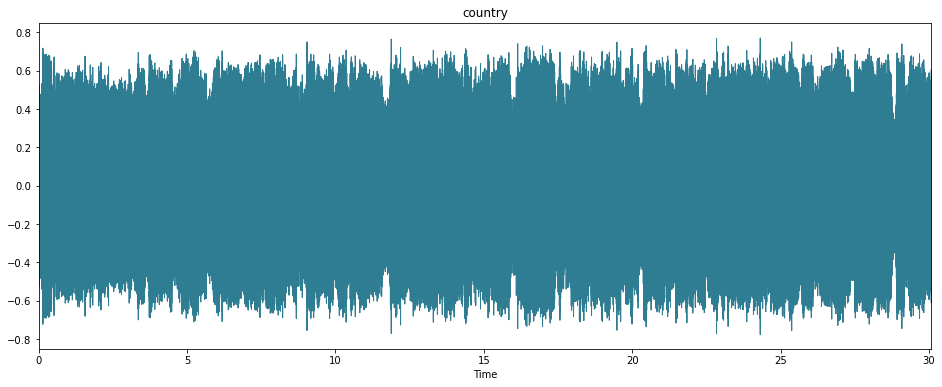

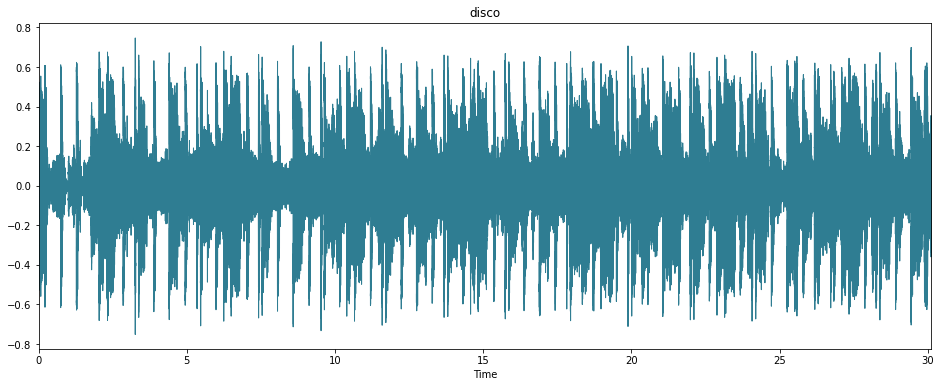

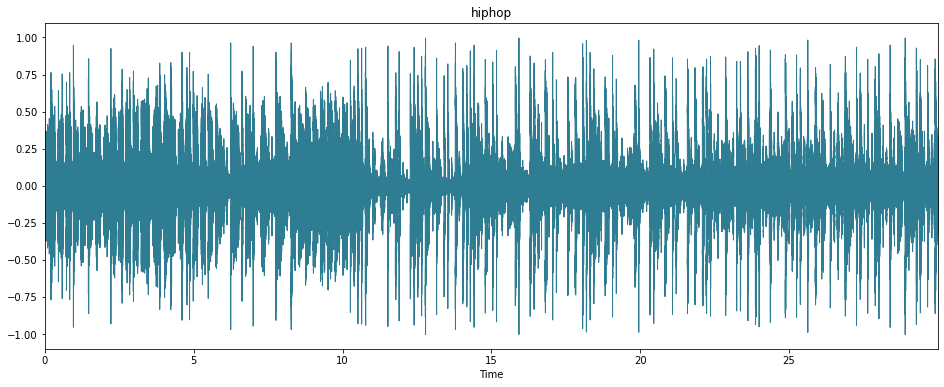

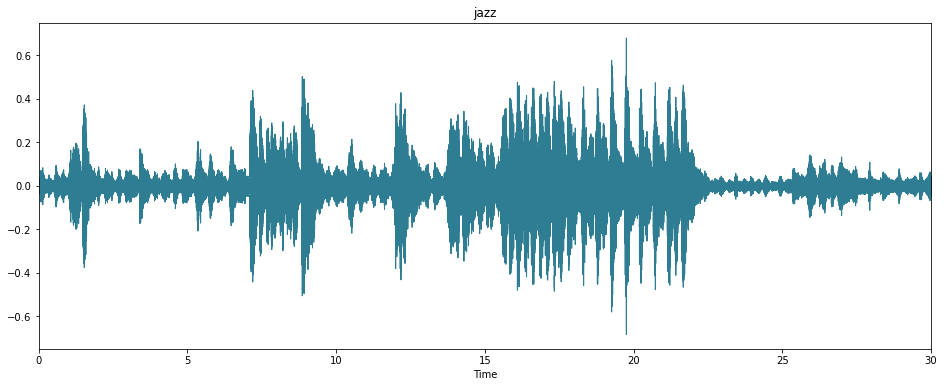

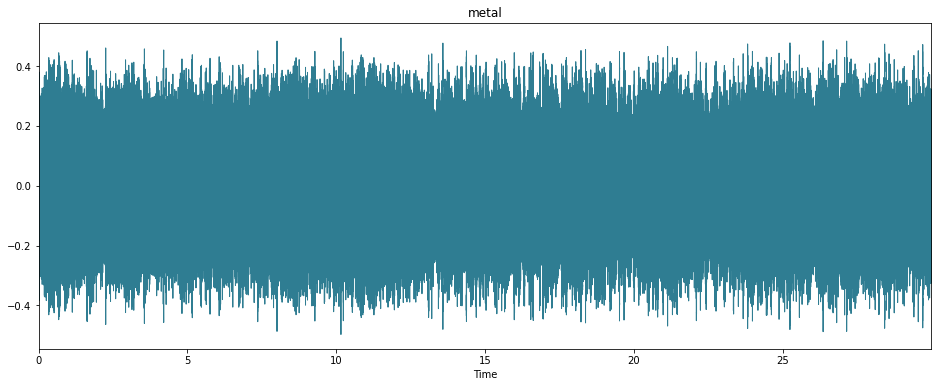

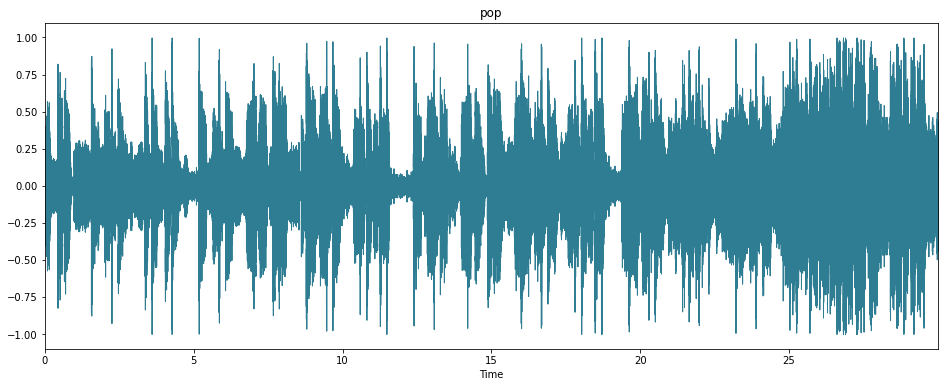

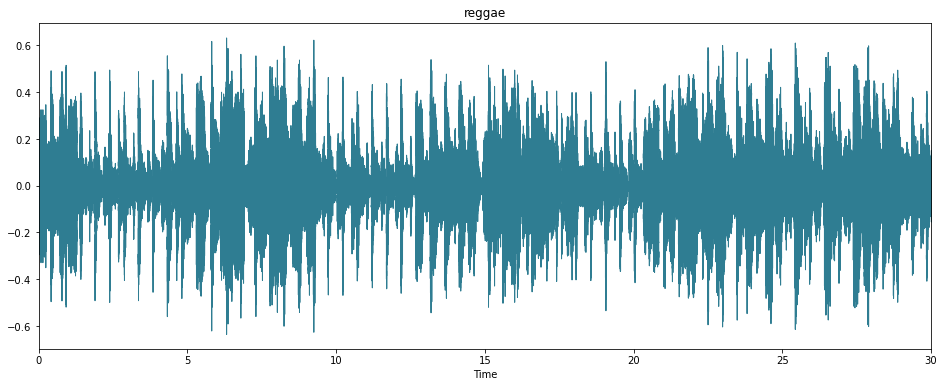

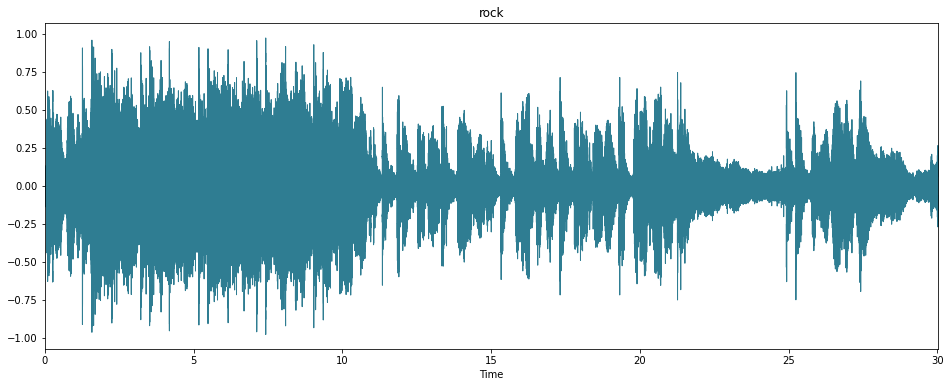

In [8]:
for sound in data_soundwaves_single:
    waveplot(sound)

In [9]:
def hermony_plot(sound_wave):
    plt.figure(figsize = (16, 6))
    plt.title(sound_wave[0])
    y_harm, y_perc = librosa.effects.hpss(sound_wave[2])
    plt.plot(y_harm, color = '#A300F9');
    plt.plot(y_perc, color = '#FFB100');
    plt.show()

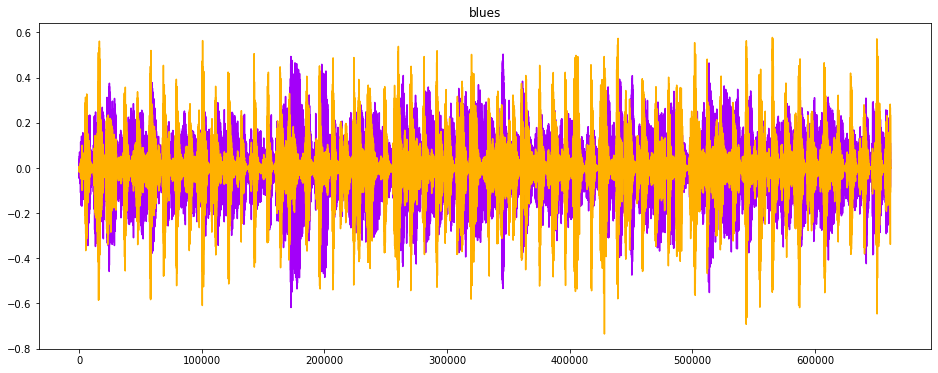

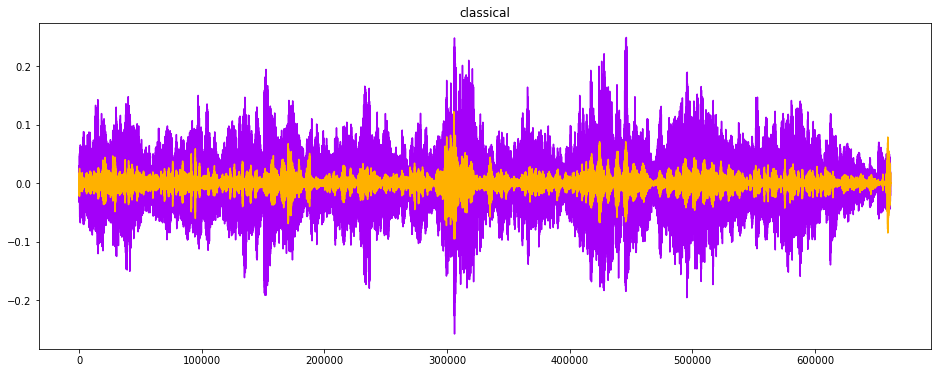

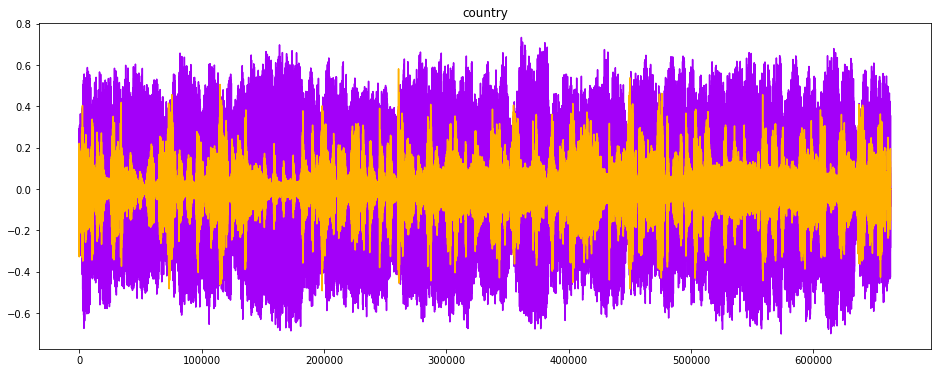

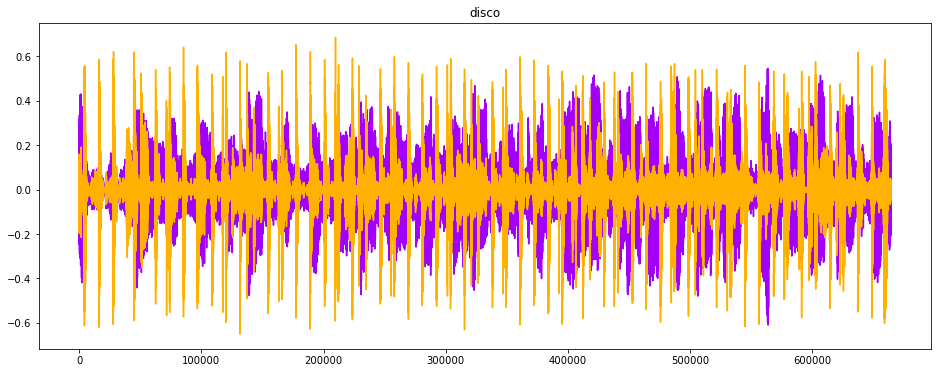

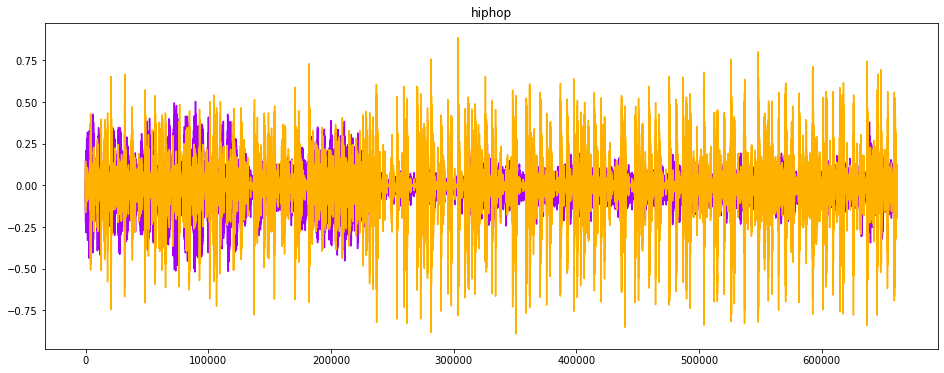

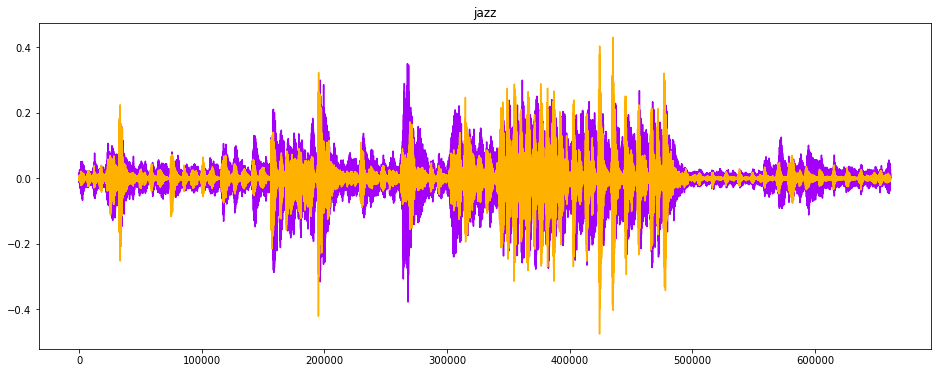

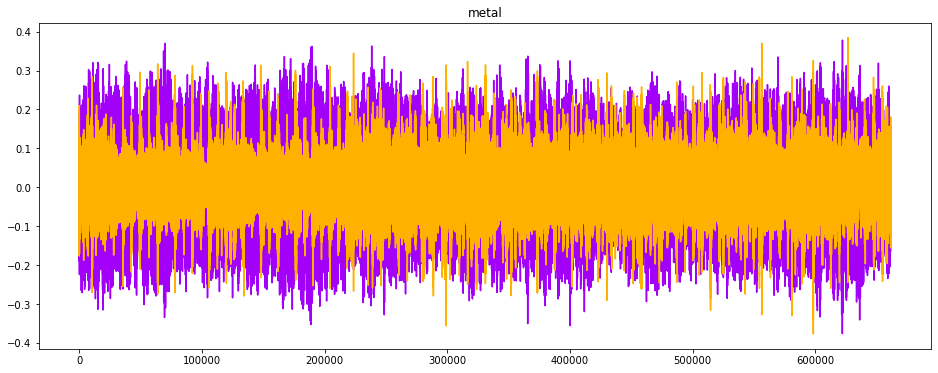

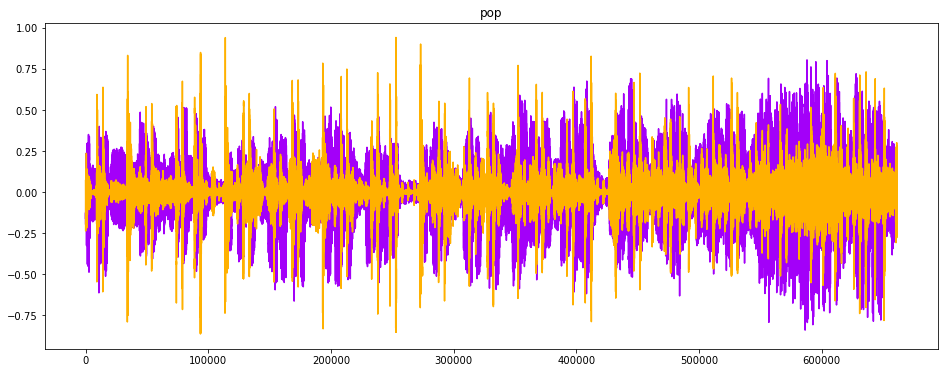

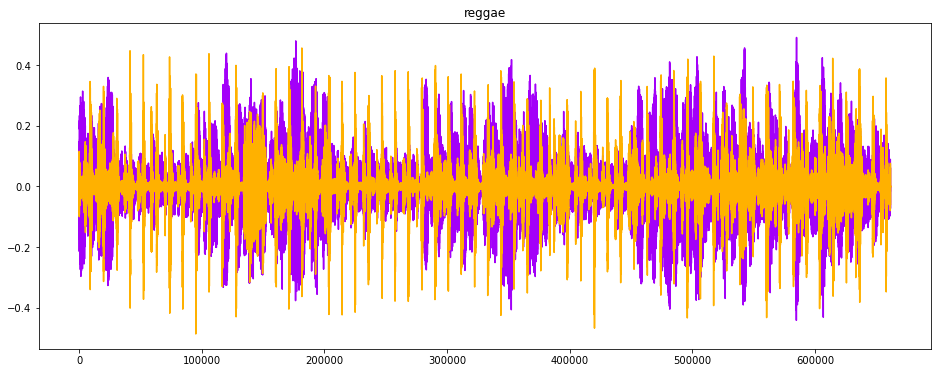

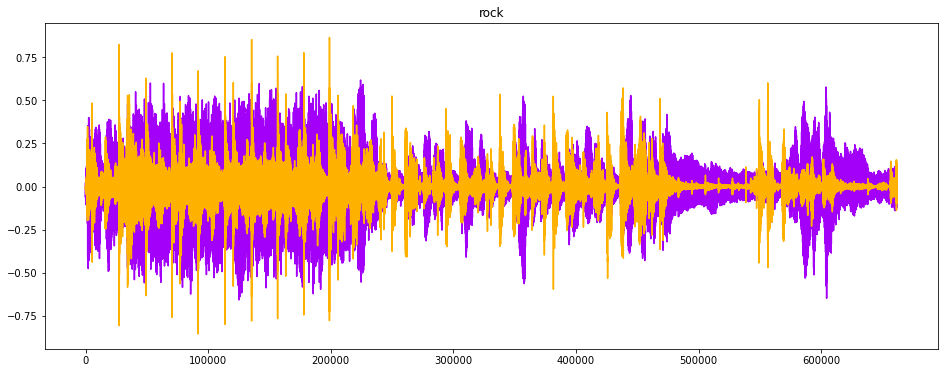

In [10]:
for sound in data_soundwaves_single:
    hermony_plot(sound)

In [11]:

hop_length = 5000
data=[]
dataset_path = ".\\Dataset\\Data\\genres_original"
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(".\\Dataset\\Data\\genres_original")):
     if dirpath is not dataset_path:
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                signal, sr = librosa.load(file_path)
                zero_crossings = librosa.zero_crossings(signal, pad=False)
                data.append([re.split(r'[_.]', f)[0],f,sum(zero_crossings)])


In [12]:
data_zerocrossings=[]
for soundwave in data_soundwaves:
    zero_crossings = librosa.zero_crossings(soundwave[2], pad=False)
    data_zerocrossings.append([soundwave[0],soundwave[1],sum(zero_crossings)])

In [13]:
df_zerocrossings = pd.DataFrame(data_zerocrossings)
df_zerocrossings

,0,1,2
0,blues,blues.00000.wav,55031
1,blues,blues.00001.wav,37139
2,blues,blues.00002.wav,50563
3,blues,blues.00003.wav,22077
4,blues,blues.00004.wav,67225
...,...,...,...
994,rock,rock.00095.wav,59124
995,rock,rock.00096.wav,64737
996,rock,rock.00097.wav,80747
997,rock,rock.00098.wav,32292


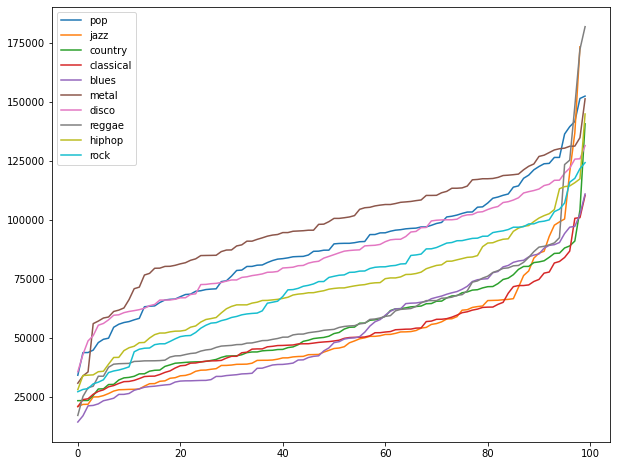

In [14]:
df_zerocrossings = df_zerocrossings.sort_values(by=[2])
set1 = set(df_zerocrossings[0])
plt.figure(figsize=(10,8))

for count in set1:
     selected_data = df_zerocrossings.loc[df_zerocrossings[0] == count]
     plt.plot(np.linspace(0, len(selected_data), len(selected_data), endpoint=False), selected_data[2], label=count)
    
plt.legend()
plt.show()

Mean: -8.8508056e-10 

Var: 1.0000001


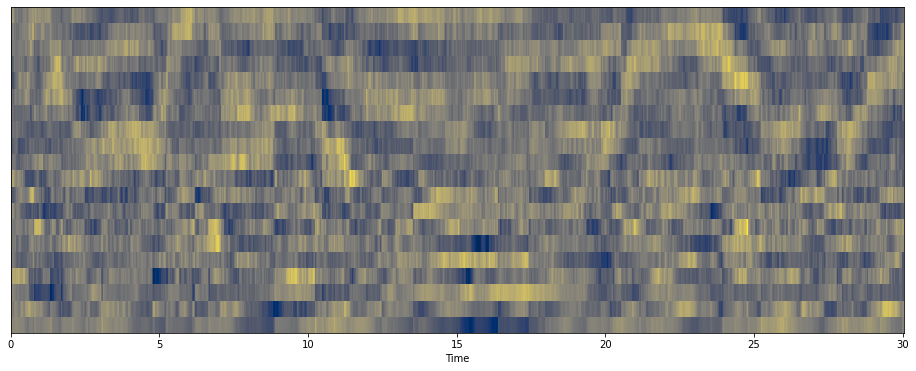

In [17]:

classical_song_path='./Dataset/Data/genres_original/classical/classical.00003.wav'
classical_sound, classical_sr =  librosa.load(classical_song_path)

mfccs = librosa.feature.mfcc(classical_sound, sr=sr)
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print('Mean:', mfccs.mean(), '\n')
print('Var:', mfccs.var())

#Displaying  the MFCCs:
plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cividis');

# Feature Extraction

In [18]:
path =".\\three_second_songs"
try: 
    os.mkdir(path) 
except OSError as error: 
    print(error)  

[WinError 183] Cannot create a file when that file already exists: '.\\three_second_songs'


In [19]:
hop_length = 5000
dataset_path = ".\\Dataset\\Data\\genres_original"
three_second_folder = ".\\three_second_songs"
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
     if dirpath is not dataset_path:
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                for i in range(0,29,3):
                    t1 = i * 1000 
                    t2 = (i+3)* 1000
                    newAudio = AudioSegment.from_wav(file_path)
                    newAudio = newAudio[t1:t2]
                    split_fn = three_second_folder +"\\" + str(i)+'_'+f 
                    newAudio.export(split_fn, format="wav")

In [20]:
def feature_extraction(dataset_path, csv_file, hop_length):

    data=[]
    mfcc_mean=[]
    mfcc_var=[]
    hop_length=hop_length

    header = ['filename','chromagram_mean','chromagram_var','rms_mean','rms_var','spectral_centroid_mean','spectral_centroid_var','spectral_bandwidth_mean','spectral_bandwidth_var','spectral_rolloff_mean','spectral_rolloff_var','zero_crossing_rate_mean','zero_crossing_rate_var','tempo_mean','y_harm_mean','y_perc_mean','y_harm_var','y_perc_var','mfccm_1','mfccm_2','mfccm_3','mfccm_4','mfccm_5','mfccm_6','mfccm_7','mfccm_8','mfccm_9','mfccm_10','mfccm_11','mfccm_12','mfccm_13','mfccm_14','mfccm_15','mfccm_16','mfccm_17','mfccm_18','mfccm_19','mfccm_20','mfccv_1','mfccv_2','mfccv_3','mfccv_4','mfccv_5','mfccv_6','mfccv_7','mfccv_8','mfccv_9','mfccv_10','mfccv_11','mfccv_12','mfccv_13','mfccv_14','mfccv_15','mfccv_16','mfccv_17','mfccv_18','mfccv_19','mfccv_20']
    file = open(csv_file, 'w', newline='')

    with file:
        writer = csv.writer(file)
        writer.writerow(header)

    dataset_path = dataset_path
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(".\\three_second_songs")):
         if dirpath is not dataset_path:
                for f in filenames:
                    file_path = os.path.join(dirpath, f)
                    signal, sr = librosa.load(file_path)
                    chromagram =librosa.feature.chroma_stft(y=signal, sr=sr, hop_length=hop_length)
                    rms =librosa.feature.rms(y=signal, hop_length=hop_length)
                    spectral_centroid =librosa.feature.spectral_centroid(y=signal, sr=sr,hop_length=hop_length)
                    spectral_bandwidth=librosa.feature.spectral_bandwidth(y=signal, sr=sr,hop_length=hop_length)
                    spectral_rolloff=librosa.feature.spectral_rolloff(y=signal, sr=sr,hop_length=hop_length)
                    zero_crossing_rate=librosa.feature.zero_crossing_rate(y=signal,hop_length=hop_length)
                    tempo = librosa.beat.tempo(y=signal)
                    y_harm, y_perc = librosa.effects.hpss(signal)
                    mfcc = librosa.feature.mfcc(y=signal,hop_length=hop_length)
                    mfccm=mfcc.mean(axis=1)
                    mfccv=mfcc.var(axis=1)

                    data=[re.split(r'[_.]', f)[1],np.mean(chromagram),np.var(chromagram),np.mean(rms),np.var(rms),np.mean(spectral_centroid),
                                 np.var(spectral_centroid),np.mean(spectral_bandwidth),np.var(spectral_bandwidth),np.mean(spectral_rolloff),
                                 np.var(spectral_rolloff),np.mean(zero_crossing_rate),np.var(zero_crossing_rate),np.mean(tempo),
                                 np.mean(y_harm),np.mean(y_perc),np.var(y_harm),np.var(y_perc)]+ mfccm.tolist()+mfccv.tolist()
                    file = open('.\\Dataset\\data_f2.csv', 'a', newline='')

                    with file:
                        writer = csv.writer(file)
                        writer.writerow(data)
            

In [21]:
feature_extraction( dataset_path=".\\three_second_songs", csv_file= ".\\Dataset\\data_f2.csv", hop_length = 5000) 

# XGBoost

In [22]:
data = pd.read_csv('.\\Dataset\\data_f2.csv') 
data.head()

,filename,chromagram_mean,chromagram_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,spectral_rolloff_mean,...,mfccv_11,mfccv_12,mfccv_13,mfccv_14,mfccv_15,mfccv_16,mfccv_17,mfccv_18,mfccv_19,mfccv_20
0,blues,0.309772,0.086180,0.122332,0.003996,1905.864620,372848.493529,2039.903690,148552.850288,3852.136230,...,63.524784,63.593975,45.755207,27.769102,42.942097,31.999884,38.952271,35.650867,38.750572,54.054966
1,blues,0.387467,0.088444,0.090634,0.004472,1441.794421,477486.108919,2012.091248,169084.665401,3373.791504,...,58.737957,100.303261,42.518818,54.139900,17.740961,34.436615,11.788865,16.438757,23.103626,24.171551
2,blues,0.342333,0.088451,0.164507,0.001718,1590.631493,106273.817134,1779.440111,57259.287100,3183.068848,...,38.177883,74.012764,29.570007,28.609316,31.235901,40.570187,60.971497,67.375412,46.838737,18.706514
3,blues,0.352511,0.095242,0.139052,0.008554,861.180590,45696.782190,1368.800379,45561.704247,1644.982910,...,18.289917,4.868769,15.948905,24.647282,16.995655,14.326455,23.700819,24.284536,20.634005,42.395073
4,blues,0.313871,0.093442,0.083485,0.000430,1538.491099,90276.969412,1582.165228,27203.154354,2903.137207,...,24.151951,64.879745,131.285553,98.364815,76.809891,70.925453,69.762062,34.877029,39.460796,71.013603


In [23]:
y = data['filename']
X = data.loc[:, data.columns != 'filename']

In [24]:
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)
X

,chromagram_mean,chromagram_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,spectral_rolloff_mean,spectral_rolloff_var,...,mfccv_11,mfccv_12,mfccv_13,mfccv_14,mfccv_15,mfccv_16,mfccv_17,mfccv_18,mfccv_19,mfccv_20
0,0.332515,0.600432,0.277464,0.103845,0.296336,0.070043,0.484431,0.127655,0.362783,0.097657,...,0.092592,0.107378,0.061823,0.022648,0.059096,0.039474,0.074981,0.056987,0.027692,0.055925
1,0.445626,0.619693,0.204973,0.116208,0.203546,0.089746,0.476106,0.145401,0.310196,0.212520,...,0.085482,0.171912,0.056959,0.046534,0.023289,0.042520,0.021644,0.022785,0.015253,0.024840
2,0.379918,0.619760,0.373910,0.044643,0.233306,0.019850,0.406465,0.048751,0.289229,0.057112,...,0.054941,0.125694,0.037497,0.023409,0.042464,0.050188,0.118217,0.113465,0.034122,0.019156
3,0.394735,0.677536,0.315699,0.222309,0.087453,0.008444,0.283545,0.038640,0.120139,0.019624,...,0.025398,0.004141,0.017025,0.019820,0.022230,0.017379,0.045034,0.036752,0.013290,0.043796
4,0.338483,0.662222,0.188627,0.011169,0.222880,0.016838,0.347413,0.022773,0.258455,0.041270,...,0.034106,0.109638,0.190372,0.086591,0.107217,0.088137,0.135478,0.055610,0.028257,0.073565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,0.343000,0.498799,0.169389,0.003365,0.243453,0.018087,0.456038,0.058697,0.340210,0.055967,...,0.080597,0.065726,0.040414,0.020662,0.087445,0.037416,0.044725,0.037189,0.008144,0.052900
9986,0.444706,0.466164,0.183337,0.004655,0.324910,0.014595,0.501899,0.025037,0.393473,0.028743,...,0.029402,0.032602,0.054363,0.020293,0.036520,0.035706,0.040024,0.044230,0.033057,0.021081
9987,0.488300,0.510223,0.158860,0.003307,0.336307,0.027356,0.467270,0.035378,0.398039,0.037827,...,0.084275,0.079385,0.029821,0.049555,0.073651,0.043600,0.055357,0.034434,0.016696,0.024678
9988,0.414832,0.730162,0.235879,0.003346,0.272972,0.047808,0.503177,0.086155,0.378086,0.091374,...,0.064881,0.051160,0.059920,0.054094,0.080313,0.025270,0.095936,0.073572,0.019196,0.041206


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:

def model_assessment(model, model_name):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print('Accuracy', model_name, ':', accuracy_score(y_test, preds))
    print('Precision', model_name, ':', precision_score(y_test, preds,average='weighted'))
    print('Recall', model_name, ':', recall_score(y_test, preds,average='weighted'))
    print('F1-score', model_name, ':', f1_score(y_test, preds,average='weighted'))
    target_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    print(classification_report(y_test, preds, target_names=target_names))  

In [27]:
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assessment(xgb, "XGBoost")

[09:35:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy XGBoost : 0.8808808808808809
Precision XGBoost : 0.8811942292994576
Recall XGBoost : 0.8808808808808809
F1-score XGBoost : 0.8807129459432106
              precision    recall  f1-score   support

       blues       0.88      0.85      0.87       333
   classical       0.91      0.95      0.93       291
     country       0.82      0.83      0.82       294
       disco       0.85      0.89      0.87       292
      hiphop       0.91      0.87      0.89       320
        jazz       0.88      0.90      0.89       298
       metal       0.93      0.93      0.93       296
         pop       0.92      0.90      0.91       315
      reggae       0.85      0.89      0.87       286
        rock       0.86      0.81      0.83       272



In [28]:
def xgbclassifier(n_estimators,learning_rate):
    xgb = XGBClassifier(n_estimators, learning_rate)
    xgb.fit(X_train, y_train)
    preds = xgb.predict(X_test)
    print('For Learning rate ', ':',learning_rate, 'and n_estimators :',n_estimators, '\n')
    print('Accuracy', ':', round(accuracy_score(y_test, preds), 4), '\n')
    confusion_matr = confusion_matrix(y_test, preds) 
    plt.figure(figsize = (16, 9))
    sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
                xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
               yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
    plt.savefig("conf matrix")

[09:39:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Learning rate  : 0.005 and n_estimators : 1000 

Accuracy : 0.8692 



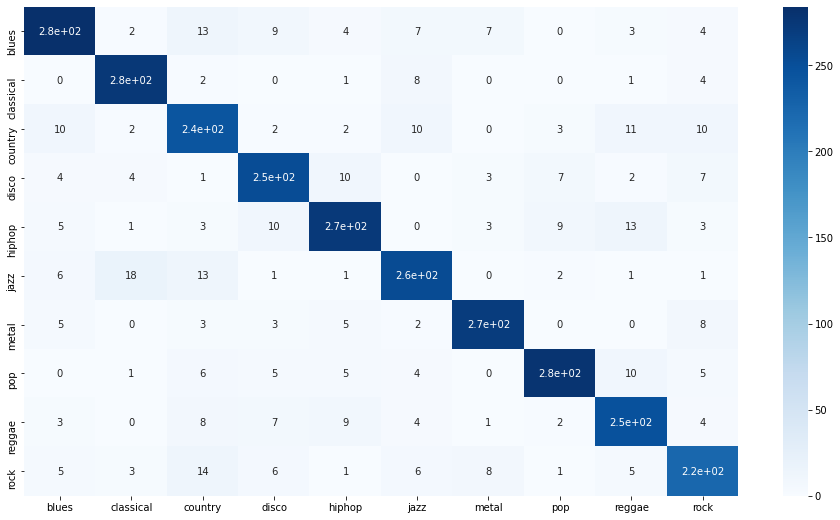

In [29]:
xgbclassifier(n_estimators=1000, learning_rate=0.005)

[09:39:44] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Learning rate  : 0.05 and n_estimators : 1000 

Accuracy : 0.8692 



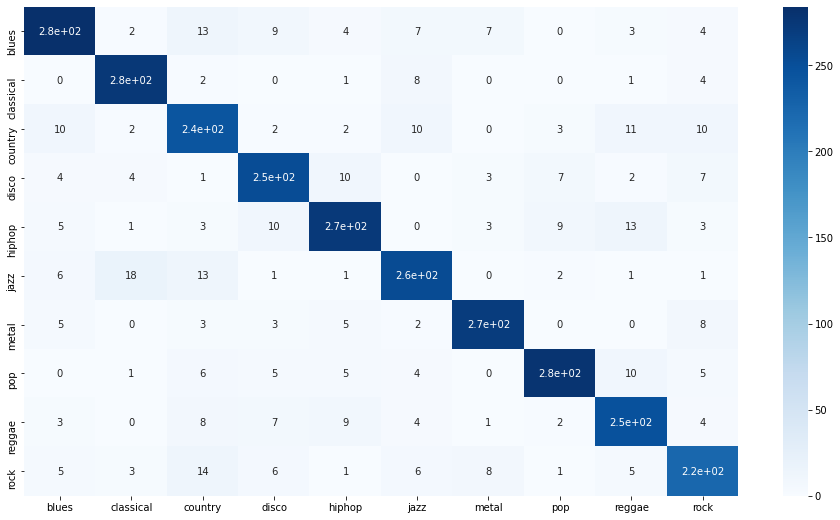

In [30]:
xgbclassifier(n_estimators=1000, learning_rate=0.05)

[09:40:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Learning rate  : 0.05 and n_estimators : 100 

Accuracy : 0.8692 



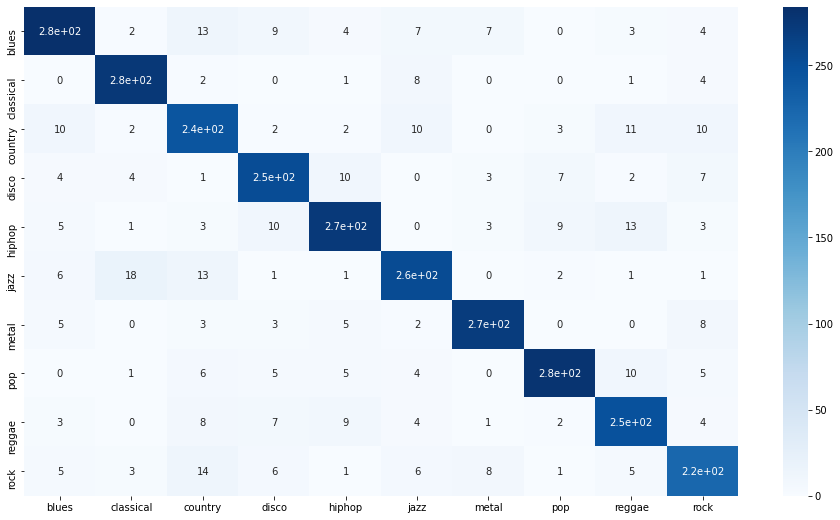

In [31]:
xgbclassifier(n_estimators=100, learning_rate=0.05)

[09:40:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Learning rate  : 0.05 and n_estimators : 500 

Accuracy : 0.8692 



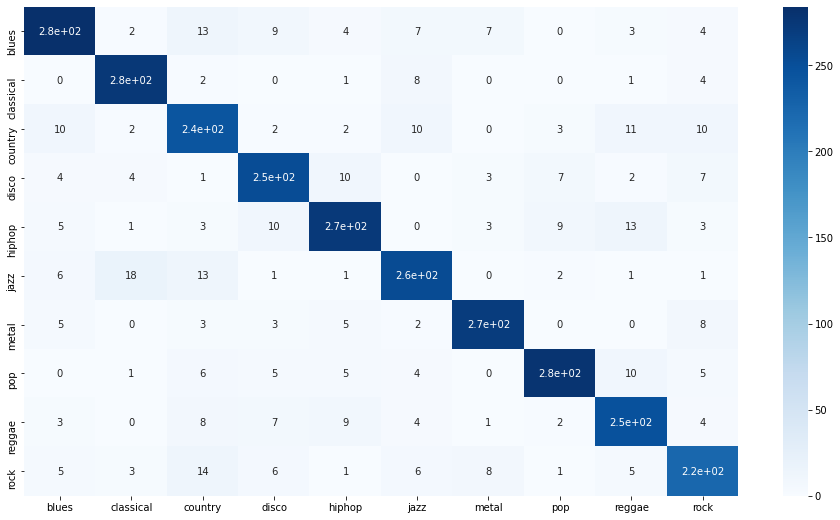

In [32]:
xgbclassifier(n_estimators=500, learning_rate=0.05)

[09:41:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Learning rate  : 0.01 and n_estimators : 1000 

Accuracy : 0.8692 



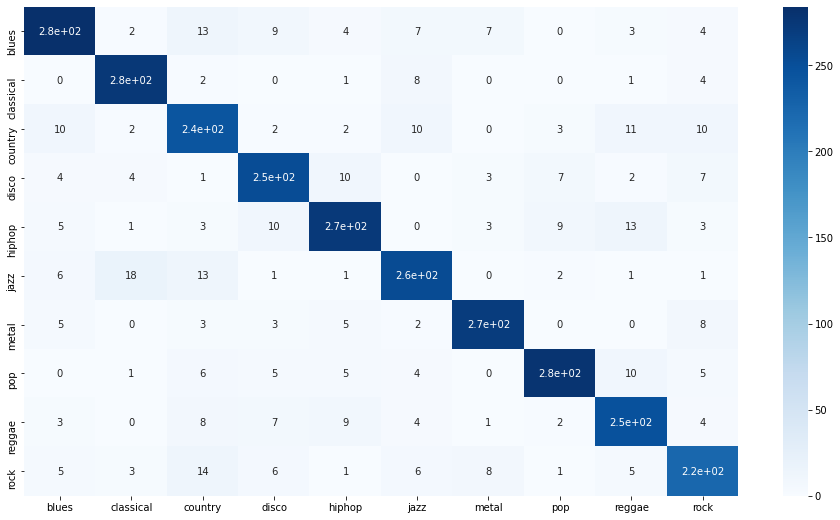

In [33]:
xgbclassifier(n_estimators=1000, learning_rate=0.01)

# CNN

In [34]:
dataset_path = ".\\three_second_songs"
data_mfcc=[]
y=[]
hop_length = 5000
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(".\\three_second_songs")):
     if dirpath is not dataset_path:
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                signal, sr = librosa.load(file_path)
                mfcc = librosa.feature.mfcc(y=signal,sr=sr)
                if(mfcc.shape[1]==130 and mfcc.shape[0]==20):
                    data_mfcc.append(mfcc.T)
                    semantic_label = file_path.split("\\")[-1]
                    y.append(re.split(r'[_.]', semantic_label)[1])    

In [35]:
data_mfcc=np.c_[data_mfcc]
data_mfcc.shape

(9986, 130, 20)

In [36]:
mydict={}
i = 0
for item in y:
    if(i>=0 and item in mydict):
        continue
    else:    
       i = i+1
       mydict[item] = i-1
k=[]
for item in y:
    k.append(mydict[item])

In [37]:
y=np.array(k)
y

array([0, 0, 0, ..., 9, 9, 9])

In [38]:
def build_model(input_shape):

    model = keras.Sequential()


    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())


    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [39]:
def predictor(model, X, y):
    X = X[np.newaxis, ...] 
    prediction = model.predict(X)
    label = np.argmax(prediction, axis=1)

    print("Target label: {}, Predicted label: {}".format(y, label))


In [40]:
if __name__ == "__main__":

    X_train, X_test, y_train, y_test = train_test_split(data_mfcc, y, test_size=0.25)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model_cnn = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=40)
    

Epoch 1/40
188/188 [==============================] - 11s 57ms/step - loss: 2.2595 - accuracy: 0.2344 - val_loss: 1.8755 - val_accuracy: 0.3478
Epoch 2/40
188/188 [==============================] - 10s 55ms/step - loss: 1.7368 - accuracy: 0.3807 - val_loss: 1.5373 - val_accuracy: 0.4479
Epoch 3/40
188/188 [==============================] - 10s 55ms/step - loss: 1.5518 - accuracy: 0.4465 - val_loss: 1.3967 - val_accuracy: 0.5047
Epoch 4/40
188/188 [==============================] - 10s 54ms/step - loss: 1.4338 - accuracy: 0.4839 - val_loss: 1.3084 - val_accuracy: 0.5320
Epoch 5/40
188/188 [==============================] - 10s 55ms/step - loss: 1.3386 - accuracy: 0.5154 - val_loss: 1.2395 - val_accuracy: 0.5621
Epoch 6/40
188/188 [==============================] - 10s 55ms/step - loss: 1.2590 - accuracy: 0.5465 - val_loss: 1.1942 - val_accuracy: 0.5688
Epoch 7/40
188/188 [==============================] - 10s 54ms/step - loss: 1.2021 - accuracy: 0.5680 - val_loss: 1.1512 - val_accuracy:

In [41]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

79/79 - 1s - loss: 0.7805 - accuracy: 0.7449

Test accuracy: 0.7448938488960266


In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 18, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 9, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 9, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 7, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 4, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 4, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 3, 32)         4

In [43]:
def plot_op(op):
    fig, axs = plt.subplots(2)
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")


    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


NameError: name 'history' is not defined

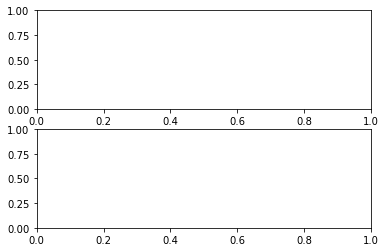

In [44]:
 plot_op(model_cnn)

In [46]:
testing=random.randint(0,100)
X_to_predict = X_test[testing]
y_to_predict = y_test[testing]

predictor(model, X_to_predict, y_to_predict)

Target label: 7, Predicted label: [7]
